# Proyecto final - Telco Customer Churn
Curso: Fundamentos de aprendizaje de máquina

Grupo 1:


*   Jhair Choco
*   Walter Valverde
*   Miguel Vega

Dataset descargado de https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

Procedimiento adaptado de https://github.com/ageron/handson-ml2/blob/master/ml-project-checklist.md


# Objetivos
El objetivo del proyecto es la elaboración de un modelo de aprendizaje de máquina para la predicción de churn de suscriptores o clientes para una empresa de telecomunicaciones.

Con dicho modelo se podrá predecir si un cliente es propenso a cancelar su suscripción o no y también qué características son las más importantes a la hora de decidir.

A nivel de negocio, el modelo podrá servir para aumentar la retención de clientes a través de campañas o promociones, así como para mejoras a nivel operativo para lograr una mayor satisfacción o experiencia de cliente.

# Inicialización

In [1]:
# Cargar librerías
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Definir opciones generales
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Lectura del dataset

In [3]:
# Descargar archivos
!wget -O 'WA_Fn-UseC_-Telco-Customer-Churn.csv' 'https://raw.githubusercontent.com/miguelvg27/ia-pucp-ml-trabajo/main/data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

--2023-11-13 04:39:54--  https://raw.githubusercontent.com/miguelvg27/ia-pucp-ml-trabajo/main/data/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 970457 (948K) [text/plain]
Saving to: ‘WA_Fn-UseC_-Telco-Customer-Churn.csv’

WA_Fn-UseC_-Telco-C 100%[===================>] 947.71K  --.-KB/s    in 0.07s   

2023-11-13 04:39:54 (13.8 MB/s) - ‘WA_Fn-UseC_-Telco-Customer-Churn.csv’ saved [970457/970457]



In [4]:
df_orig = pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")
df_orig.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


El dataset cuenta con las siguientes columnas según la documentación:

|Nombre|Descripción|
|---|---|
|customerID|Identificador del cliente|
|gender|Género del cliente|
|SeniorCitizen|Indica si el cliente es adulto mayor|
|Partner|Indicas si el cliente tiene una empresa partner|
|Dependantas|Indica si el cliente tiene dependientes|
|tenure|Cantidad de meses de suscripción del cliente|
|PhoneService|Indica si el cliente tiene servicio telefónico|
|MultipleLines|Indica si el cliente tiene varias líneas telefónicas|
|InternetService|Indica el tipo de servicio de internet del cliente|
|OnlineSecurity|Indica si tiene seguridad online en su paquete de internet|
|OnlineBackup|Indica si tiene backups online en su paquete de internet|
|DeviceProtection|Indica si tiene protección de dispositivos en su paquete de internet|
|TechSupport|Indica si tiene soporte técnico en su paquete de internet|
|StreamingTV|Indica si tiene el servicio de streaming tv en su paquete de internet|
|StreamingMovies|Indica si tiene el servicio de streaming de películas en su paquete de internet|
|Contract|Texto|Indica el tipo de contrato del cliente|
|PaperlessBilling|Indica si el clientetiene facturación electrónica|
|PaymentMethod|Método de pago del cliente|
|MonthlyCharges|Cargos mensuales del cliente|
|TotalCharges|Cargos históricos acumulados del cliente|
|Churn|Etiqueta|Indica si el cliente canceló su sucripción|

In [5]:
df_orig.shape

(7043, 21)

El dataset tiene 7043 instancias, utilizaremos un 20% para el conjunto de pruebas

In [6]:
df_orig.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Llama la atención que SeniorCitizen sea la única variable categórica con tipo de dato Entero. Así mismo, TotalCharges debería ser numérica.

## Preprocesamiento de datos
Por conveniencia, se transformarán algunos datos previo a su visualización.

*SeniorCitizen* es una característica categórica. Por el momento la pasaremos a Yes/No como el resto de características categóricas del dataset. De tal manera, no se mezclará con los datos numéricos

In [7]:
df_orig['SeniorCitizen'] = df_orig['SeniorCitizen'].apply(lambda x: 'Yes' if x==1 else ('No' if x==0 else x))
df_orig['SeniorCitizen'].value_counts()

No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64

*TotalCharges* debería ser *float64* y aparece como *object*.

In [8]:
df_orig['TotalCharges'].isna().sum()

0

Convertimos a NaN los vacíos y convertimos a float

In [9]:
df_orig['TotalCharges'] = df_orig['TotalCharges'].replace(' ', np.nan)
df_orig['TotalCharges'] = pd.to_numeric(df_orig['TotalCharges'], errors='raise')
df_orig['TotalCharges'].isna().sum()

11

## Vistazo inicial
Realizamos un vistazo inicial antes de generar el conjunto de pruebas

In [10]:
df_orig.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000,7043.000,7032.000
mean,32.371,64.762,2283.300
std,24.559,30.090,2266.771
min,0.000,18.250,18.800
25%,9.000,35.500,401.450
50%,29.000,70.350,1397.475
75%,55.000,89.850,3794.738
max,72.000,118.750,8684.800


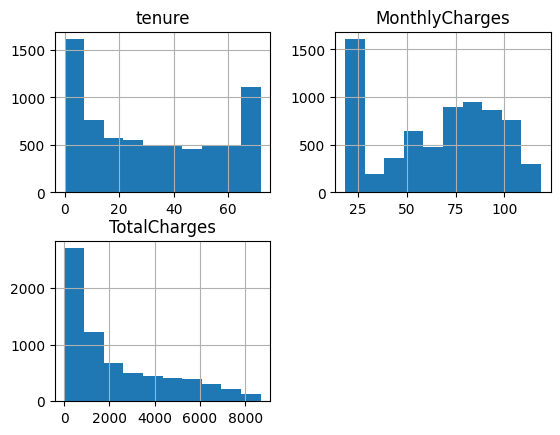

In [11]:
fig = df_orig.hist()

A simple vista se puede observar lo siguiente:


*   tenure acumula varias instancias en valores muy bajos o muy altos, probablemente haya mayor cantidad de clientes nuevos y clientes antiguos. Tal vez a partir de cierto mes la satisfacción del cliente o la presión de la competencia comienza a ocasionar cancelaciones
*   MonthlyCharges acumula varias instancias en valores bajos, probablemnte clientes con planes más baratos
*   TotalCharges tiene uns distribución sesgada, veremos cómo atacar este fenómeno después de crear el conjunto de pruebas


## Conjunto de pruebas
Se generará un conjunto de pruebas balanceado

In [12]:
df_orig['Churn'].value_counts() / len(df_orig)

No    0.735
Yes   0.265
Name: Churn, dtype: float64

Se utilizará la clase StratifiedShuffleSplit para generar los conjuntos estratificados por la etiqueta Churn. El tamaño del conjunto de pruebas será de un 20% del dataset

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df_orig, df_orig['Churn']):
  df_train = df_orig.loc[train_index]
  df_test = df_orig.loc[test_index]

Se valida la distribución

In [14]:
df_train['Churn'].value_counts() / len(df_train)

No    0.735
Yes   0.265
Name: Churn, dtype: float64

In [15]:
df_test['Churn'].value_counts() / len(df_test)

No    0.735
Yes   0.265
Name: Churn, dtype: float64

# Exporación de datos
Se estudiarán las columnas del conjunto de entrenamiento y sus características:


*   Nombre
*   Tipo de dato
*   Valores faltantes
*   Utilidad
*   Valores atípicos (para características numéricas)
*   Tipo de distribución (para características numéricas)
*   Correlaciones
*   Posibles transformaciones

## Visualización de los datos
A continuación, se visualizarán los datos con el fin de encontrar mayor información de las características



### Datos numéricos

In [16]:
df = df_train.copy()

In [17]:
car_num = df.select_dtypes(include=['float64','int64']).columns.to_list()
car_num

['tenure', 'MonthlyCharges', 'TotalCharges']

In [18]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,5634.000,5634.000,5626.000
mean,32.485,64.930,2302.604
std,24.569,30.138,2279.173
min,0.000,18.400,18.850
25%,9.000,35.663,407.275
50%,29.000,70.500,1398.125
75%,55.000,90.000,3838.613
max,72.000,118.750,8684.800


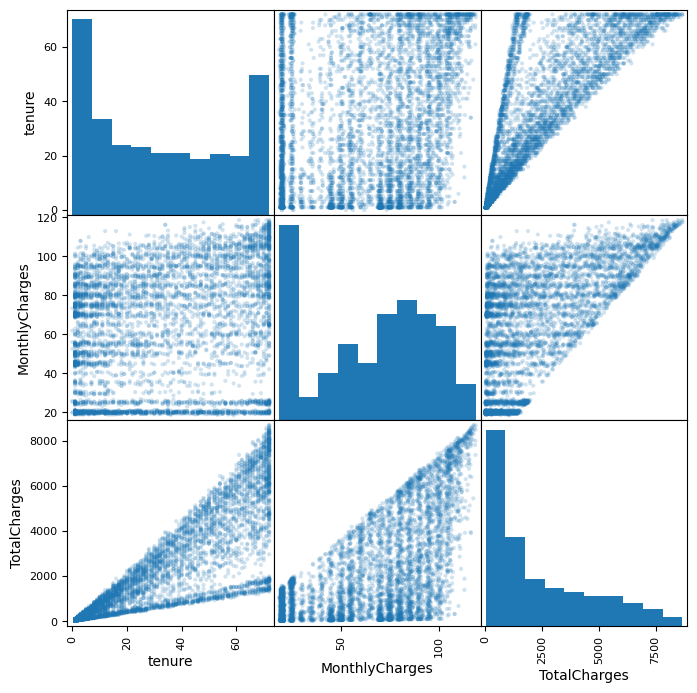

In [19]:
from pandas.plotting import scatter_matrix
fig = scatter_matrix(df, alpha=0.2, figsize=(8, 8), diagonal='hist')

En el gráfico se puede observar que la característica TotalCharges tiene una distribución sesgada.

#### Valores atípicos

Se procede a visualizar la característica TotalCharges

In [20]:
df['TotalCharges'].skew()

0.9475162595460518

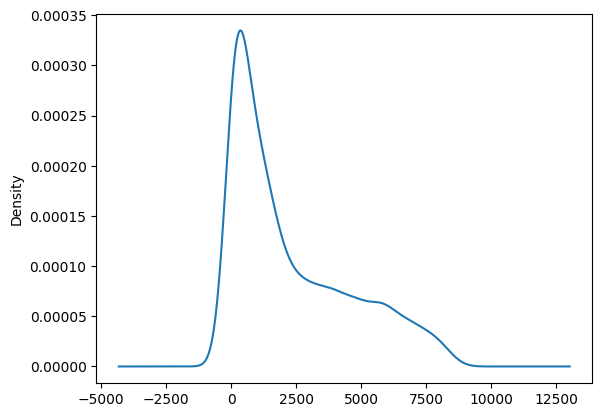

In [21]:
fig = df['TotalCharges'].plot.kde()

<Axes: >

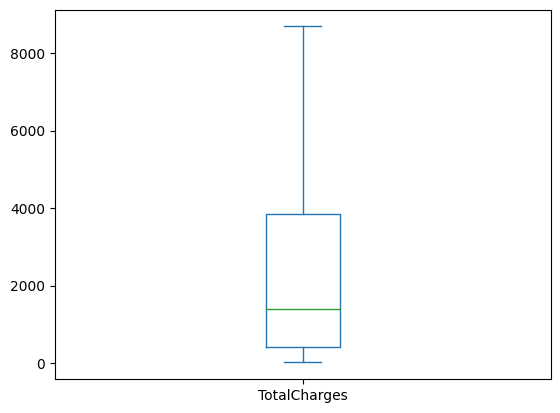

In [22]:
df['TotalCharges'].plot.box()

Para reducir el skew o asímetría y el impacto de los valores atípicos de la cola derecha, se podría aplicar un logaritmo en la ingeniería de características.

In [23]:
df["TotalChargesLog"] = df["TotalCharges"].apply(np.log)

In [24]:
df['TotalChargesLog'].skew()

-0.7551070489827763

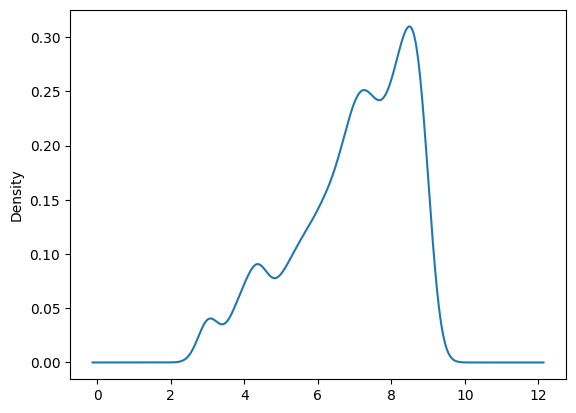

In [25]:
fig = df['TotalChargesLog'].plot.kde()

La asimetría se ha reducido un poco (de 0.95 a 0.75), por lo que procederemos con esta transformación.

#### Correlación
Visualizamos las variables numéricas vs la etiqueta Churn y revisamos la matriz de correlación

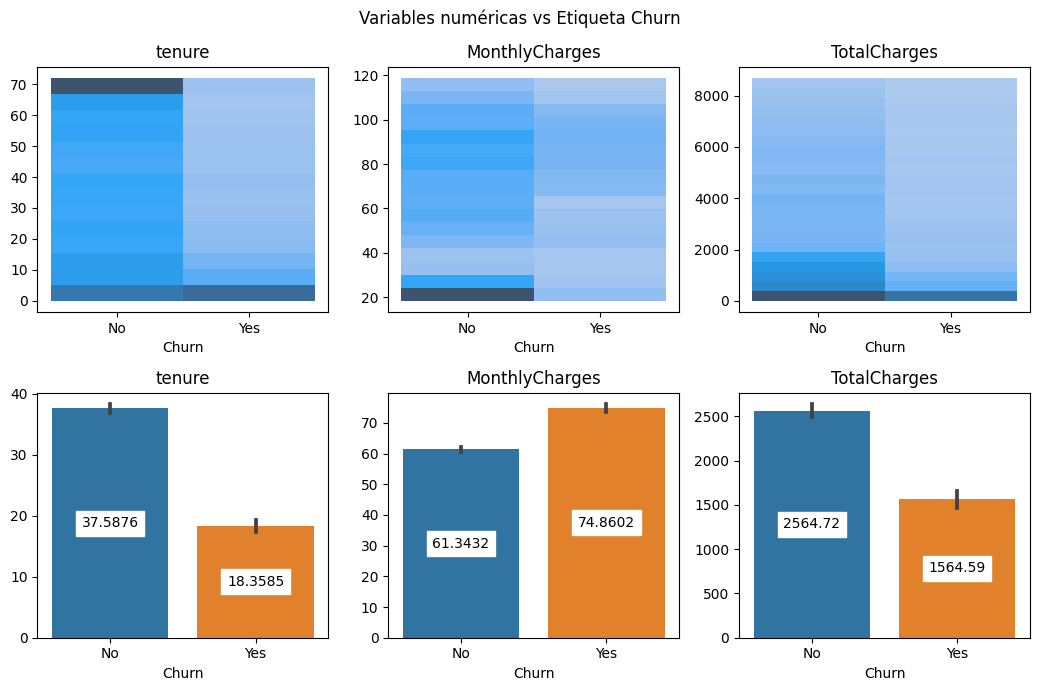

In [26]:
fig, axes = plt.subplots(2, len(car_num), figsize=(len(car_num) * 3.5, 2 * 3.5))
fig.suptitle('Variables numéricas vs Etiqueta Churn')
axes = axes.flatten()

for yi in range(0,len(car_num)):
  ax = axes[yi]
  ax.set_title(car_num[yi])
  sns.histplot(data=df.fillna(0), x='Churn', y=car_num[yi], ax=ax)
  ax.set_ylabel('')

for yi in range(len(car_num),len(car_num)*2):
  ax = axes[yi]
  ax.set_title(car_num[yi-len(car_num)])
  sns.barplot(data=df.fillna(0), x='Churn', y=car_num[yi-len(car_num)], ax=ax, estimator=np.mean)
  ax.bar_label(ax.containers[0], label_type="center", backgroundcolor="w");
  ax.set_ylabel('')

plt.tight_layout()
plt.show()

A continuación, visualizamos la matriz de correlación. Convertimos la etiqeuta a entero para ver si nos da alguna información.

In [27]:
df['Churn_int'] = df['Churn'].apply(lambda x: 1 if x=='Yes' else 0)
car_num.append('Churn_int')

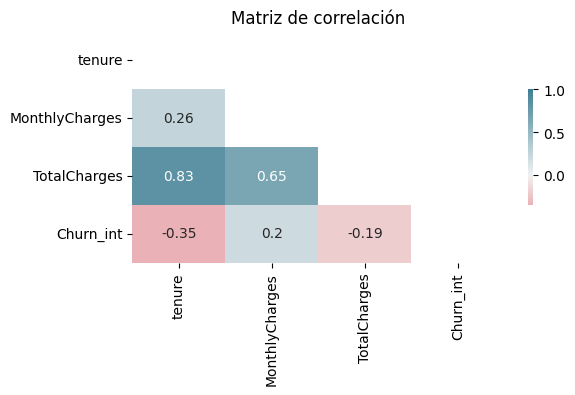

In [28]:
corr = df[car_num].corr(numeric_only=True)
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(6, 3))
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, cbar_kws={"shrink": .5}, annot=True)
plt.title("Matriz de correlación")
fig.show()

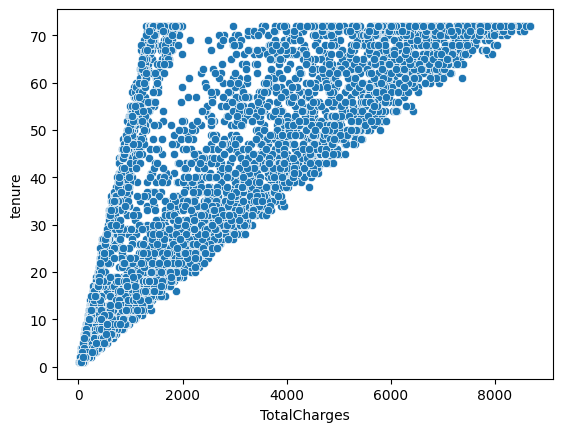

In [29]:
ax = sns.scatterplot(x="TotalCharges", y="tenure", data=df)

La matriz indica que la correlación y entre las característica TotalCharges y tenure es alta, lo cual es lógico, pues entre más tiempo se esté suscrito a un servicio, aumentan los cargos totales. Lo mismo se puede concluir al visualizar el scatterplot. No obstante, no se encuentra necesario unificar ambas características o retirar alguna, pues se consideran ambas variables lo suficientemente importantes y nos pueden dar buenas perspectivas en relación al problema.

### Datos categóricos

In [30]:
car_cat = df.select_dtypes(include=['object']).columns
car_cat = car_cat.drop(["customerID", "Churn"])
len(car_cat)

16

Se grafican las variables categóricas vs la etiqueta churn

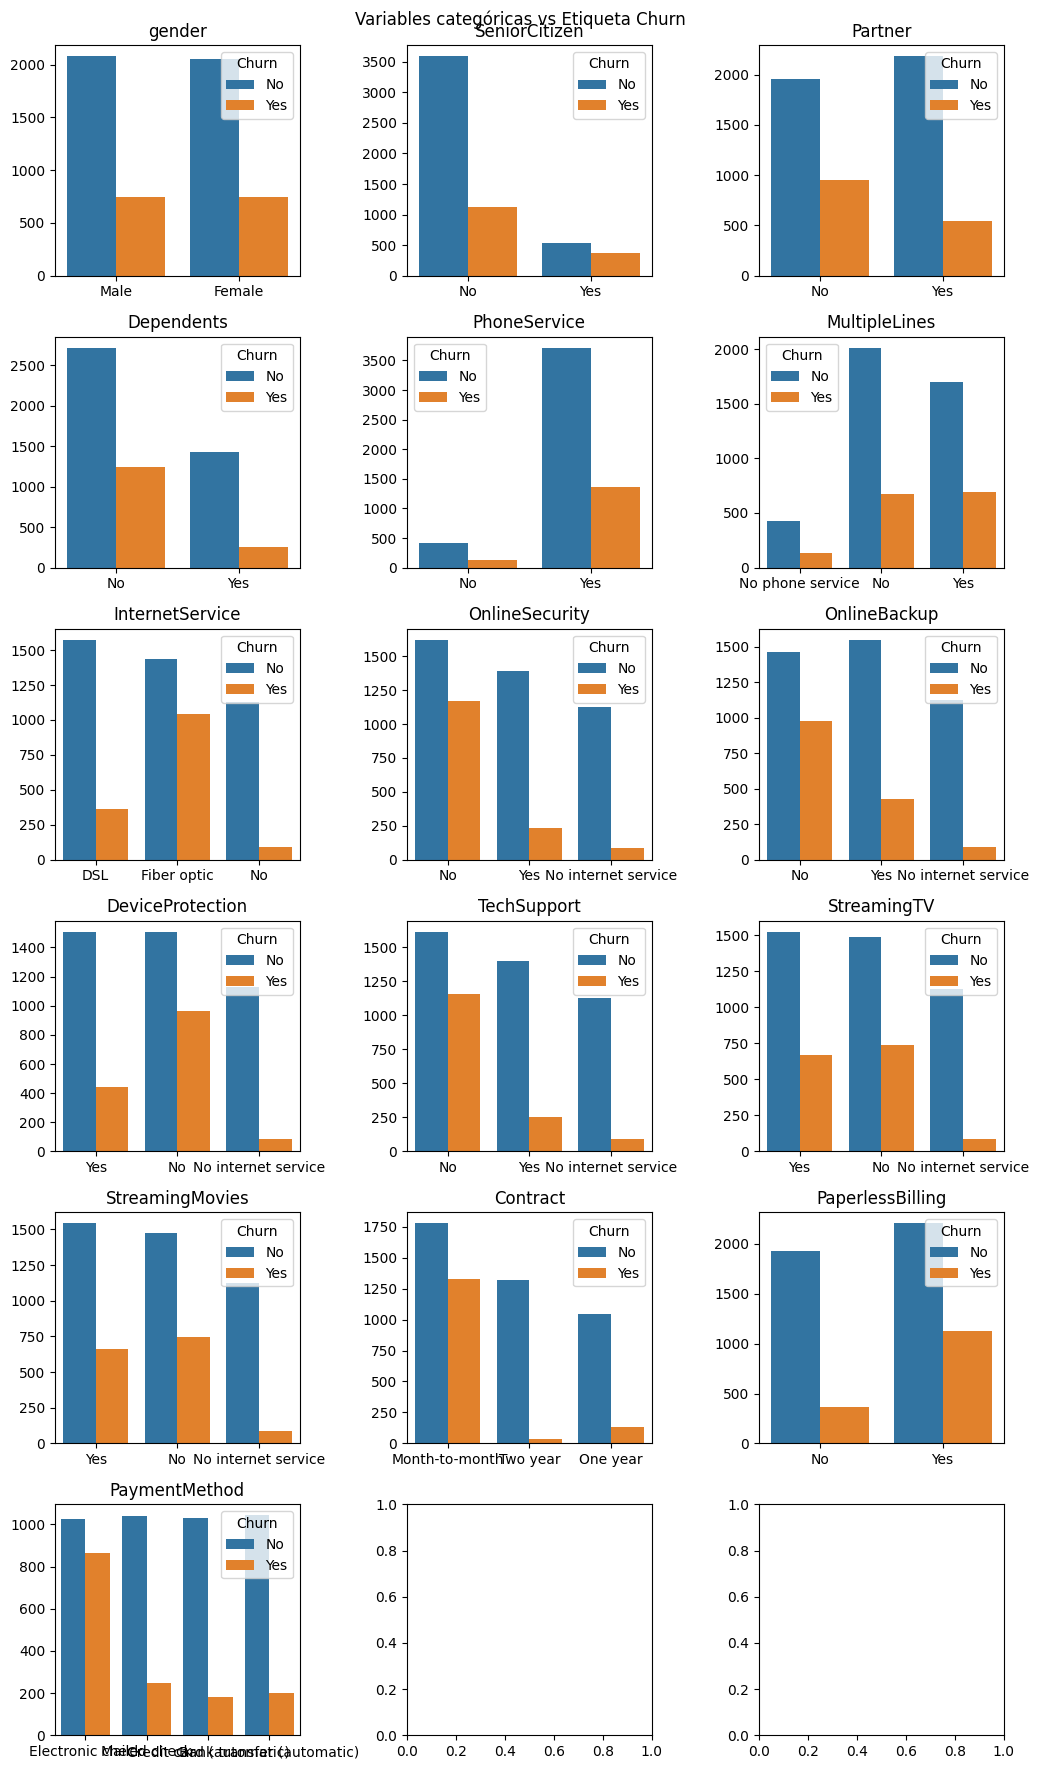

In [31]:
n_columnas = 3
n_filas = math.ceil(len(car_cat)/n_columnas)
fig, axes = plt.subplots(n_filas, n_columnas, figsize=(n_columnas * 3.5, n_filas * 3))
fig.suptitle('Variables categóricas vs Etiqueta Churn')
axes = axes.flatten()

for yi in range(0,len(car_cat)):
  ax = axes[yi]
  ax.set_title(car_cat[yi])
  sns.countplot(data=df, hue='Churn', x=car_cat[yi], ax=ax)
  ax.set_ylabel('')
  ax.set_xlabel('')

plt.tight_layout()
plt.show()

No se visualiza nada fuera de lo normal

#### Categorías redundantes
Para las características que tienen más de una clase se utilizará el OneHotEncoder para la generación de las categorías dummy. No obstante, hay unas categorías de dichas características que parecen redundantes y si las retiramos podemos convertir dichas características en binarias y reducir la dimensionalidad

Se visualiza que la característica MultipleLines tiene una clase 'No phone service'. Así mismo, ya existe una característica PhoneService. Nuestra hipótesis es que todas las instancias con PhoneService = No tendrán MultipleLines = 'No phone service'

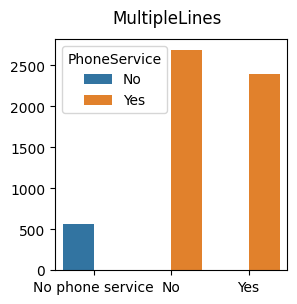

In [32]:
fig, ax = plt.subplots(figsize=(3,3))
fig.suptitle('MultipleLines')
sns.countplot(data=df, hue='PhoneService', x='MultipleLines')
ax.set_xlabel('')
ax.set_ylabel('')
fig.show()

Se confirma que siempre que PhoneService = No, MultipleLines = 'No phone service'. Por lo que si tenemos una categoría dummy MultipleLines_NoPhoneService, esta sería redundante con PhoneService. Por ello, se pasarán todos los valores de 'No phone service' a No y se mantendrá solo una característica binaria MultipleLines

Se realiza el mismo ejercicio para InternetService y OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV y StreamingMovies

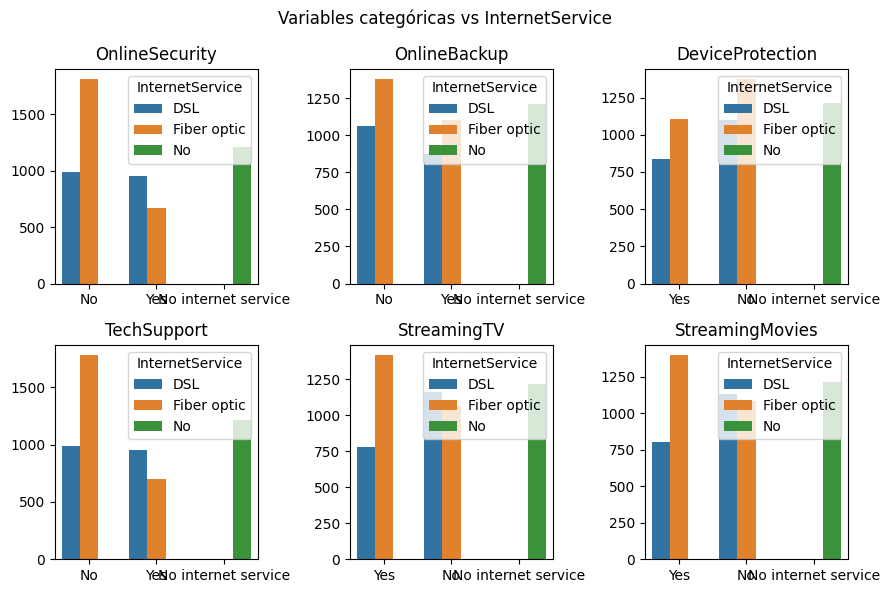

In [33]:
car_redundantes = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
n_columnas = 3
n_filas = 2
fig, axes = plt.subplots(n_filas, n_columnas, figsize=(n_columnas * 3, n_filas * 3))
fig.suptitle('Variables categóricas vs InternetService')
axes = axes.flatten()

for yi in range(0,len(car_redundantes)):
  ax = axes[yi]
  ax.set_title(car_redundantes[yi])
  sns.countplot(data=df, hue='InternetService', x=car_redundantes[yi], ax=ax)
  ax.set_ylabel('')
  ax.set_xlabel('')

plt.tight_layout()
plt.show()

Se confirma que siempre que alguna de dichas características es igual a 'No internet service', InternetService = No, por lo que si se tuviese una característica dummy para 'No internet service', contendría la misma información que InternetService

### Valores faltantes

In [34]:
df.count()

customerID          5634
gender              5634
SeniorCitizen       5634
Partner             5634
Dependents          5634
tenure              5634
PhoneService        5634
MultipleLines       5634
InternetService     5634
OnlineSecurity      5634
OnlineBackup        5634
DeviceProtection    5634
TechSupport         5634
StreamingTV         5634
StreamingMovies     5634
Contract            5634
PaperlessBilling    5634
PaymentMethod       5634
MonthlyCharges      5634
TotalCharges        5626
Churn               5634
TotalChargesLog     5626
Churn_int           5634
dtype: int64

Solo la característica TotalCharges tiene valores faltantes. Visualizaremos los datos faltantes

In [35]:
df[['tenure','TotalCharges','MonthlyCharges','Churn']][df['TotalCharges'].isna()]

,tenure,TotalCharges,MonthlyCharges,Churn
6670,0,NaN,73.350,No
4380,0,NaN,20.000,No
3826,0,NaN,25.350,No
488,0,NaN,52.550,No
1082,0,NaN,25.750,No
1340,0,NaN,56.050,No
6754,0,NaN,61.900,No
3331,0,NaN,19.850,No


Se visualiza que el tenure es 0 para dichas instancias. Por ello, se rellenará el campo TotalCharges con el valor de MonhtlyCharges, pues son clientes a los que todavía no se les ha facturado su primer pago. Otra opción sería asignarle 0, pero complicaría la conversión logarítmica.

In [36]:
unique_vals = df.select_dtypes("O").nunique()
unique_vals

customerID          5634
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
Churn                  2
dtype: int64

## Resumen de los datos
A continuación, se resumen las principales características de las columnas del archivo.

|Nombre|Tipo|Tipo de dato|Rango de valores|Comentarios|
|---|---|---|---|---|
|customerID||Texto||Se retirará la característica, pues no da información|
|gender|Binaria|Texto|Male, Female|Se utilizará OrdinalEncoder, pues es binario|
|SeniorCitizen|Binaria|Entero|1=Sí, 0=No|Se utilizará OrdinalEncoder, pues es binario|
|Partner|Binaria|Texto|Yes, No|Se utilizará OrdinalEncoder, pues es binario|
|Dependantas|Binaria|Texto|Yes, No|Se utilizará OrdinalEncoder, pues es binario|
|tenure|Numérica|Entero|[0-72]|Se usará StandardScaler|
|PhoneService|Binaria|Texto|Yes, No|Se utilizará OrdinalEncoder, pues es binario|
|MultipleLines|Binaria|Texto|Yes, No, No phone service|Se homologará No con No phone service y se utilizará OrdinalEncoder como si fuese binario|
|InternetService|Categórica|Texto|DSL, Fiber optic, No|Se utilizará OneHotEncoder, pues tiene más de dos posibles valores|
|OnlineSecurity|Binaria|Texto|Yes, No, No internet service|Se homologará No con No internet service y se utilizará OrdinalEncoder como si fuese binario|
|OnlineBackup|Binaria|Texto|Yes, No, No internet service|Se homologará No con No internet service y se utilizará OrdinalEncoder como si fuese binario|
|DeviceProtection|Binaria|Texto|Yes, No, No internet service|Se homologará No con No internet service y se utilizará OrdinalEncoder como si fuese binario|
|TechSupport|Binaria|Texto|Yes, No, No internet service|Se homologará No con No internet service y se utilizará OrdinalEncoder como si fuese binario|
|StreamingTV|Binaria|Texto|Yes, No, No internet service|Se homologará No con No internet service y se utilizará OrdinalEncoder como si fuese binario|
|StreamingMovies|Binaria|Texto|Yes, No, No internet service|Se homologará No con No internet service y se utilizará OrdinalEncoder como si fuese binario|
|Contract|Categórica|Texto|Month-to-month, One year, Two year|Se utilizará OneHotEncoder, pues tiene más de dos posibles valores|
|PaperlessBilling|Binaria|Texto|Yes, No|Se utilizará OrdinalEncoder, pues es binario|
|PaymentMethod|Categórica|Texto|Electronic check, Mailed check, Bank transfer, Credit card|Se utilizará OneHotEncoder, pues tiene más de dos posibles valores|
|MonthlyCharges|Numérico|Real|[18.25,118.75]|Se utilizará StandardScaler|
|TotalCharges|Numérico|Real|[18.8,8684.80]|Se imputarán MonthlyCharges a los valores faltantes, se aplicará logaritmo para reducir la asimetrías y se utilizará StandarScaler|
|Churn|Etiqueta|Texto|Yes, No|Se utilizará el LabelEncoder para el entrenamiento|


# Preparación de los datos

En esta sección, se procesará el dataset para que quede listo para su entrenamiento.

## Eliminar características

Se retiran las característiacs que no proporcionan información

In [37]:
X_train_pre = df_train.drop(columns=['customerID','Churn'], errors='ignore').copy()
X_test_pre = df_test.drop(columns=['customerID','Churn'], errors='ignore').copy()

Se separa la etiqueta de los conjuntos de datos

In [38]:
y_train_pre = df_train['Churn'].copy()
y_test_pre = df_test['Churn'].copy()

## Imputar valores faltantes

Se imputarán los valores faltantes a TotalCharges

In [39]:
X_train_pre['TotalCharges'].isna().sum()

8

In [40]:
X_train_pre['TotalCharges'].fillna(X_train_pre['MonthlyCharges'],inplace=True)
X_test_pre['TotalCharges'].fillna(X_test_pre['MonthlyCharges'],inplace=True)

In [41]:
X_train_pre['TotalCharges'].isna().sum()

0

In [42]:
X_train_pre.describe() # se completa el count

,tenure,MonthlyCharges,TotalCharges
count,5634.000,5634.000,5634.000
mean,32.485,64.930,2299.394
std,24.569,30.138,2279.145
min,0.000,18.400,18.850
25%,9.000,35.663,402.975
50%,29.000,70.500,1394.925
75%,55.000,90.000,3835.825
max,72.000,118.750,8684.800


## Ingeniería de características
A continuación, se realizarán las descomposiciones y transformaciones necesarias

### Descomposición de variables categóricas
Se utilizará OrdinalEncoder para las características binarias y OneHotEncoder para las características categóricas.

Primero, se eliminarán las categorías redundantes.

In [43]:
car_redundantes = ['MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for car in car_redundantes:
  X_train_pre[car] = X_train_pre[car].apply(lambda x: 'Yes' if x=='Yes' else 'No')
  X_test_pre[car] = X_test_pre[car].apply(lambda x: 'Yes' if x=='Yes' else 'No')

Se definen arreglos con las categorías de cada tipo

In [44]:
unique_vals = X_train_pre.select_dtypes("O").nunique()
car_bin = unique_vals[unique_vals == 2].index.to_list()
car_cat = unique_vals[unique_vals > 2].index.to_list()
etiqueta = 'Churn'

car_bin,car_cat

(['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'PaperlessBilling'],
 ['InternetService', 'Contract', 'PaymentMethod'])

In [45]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

ordinal_encoder.fit(X_train_pre[car_bin])
X_train_bin = ordinal_encoder.transform(X_train_pre[car_bin])
X_train_bin

array([[1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [46]:
ordinal_encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

In [47]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder()

onehot_encoder.fit(X_train_pre[car_cat])
X_train_cat = onehot_encoder.transform(X_train_pre[car_cat])
X_train_cat.toarray()

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [48]:
onehot_encoder.categories_

[array(['DSL', 'Fiber optic', 'No'], dtype=object),
 array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['Bank transfer (automatic)', 'Credit card (automatic)',
        'Electronic check', 'Mailed check'], dtype=object)]

### Escalamiento de datos numéricos

Como propuesto, se convierte TotalCharges a logaritmo

In [49]:
X_train_pre['TotalChargesLog'] = X_train_pre['TotalCharges'].apply(np.log)
X_test_pre['TotalChargesLog'] = X_test_pre['TotalCharges'].apply(np.log)

In [50]:
car_num = X_train_pre.select_dtypes(include=['float64','int64']).columns.to_list()
car_num.remove('TotalCharges') if 'TotalCharges' in car_num else None
car_num

['tenure', 'MonthlyCharges', 'TotalChargesLog']

In [51]:
X_train_pre.describe()

,tenure,MonthlyCharges,TotalCharges,TotalChargesLog
count,5634.000,5634.000,5634.000,5634.000
mean,32.485,64.930,2299.394,6.945
std,24.569,30.138,2279.145,1.556
min,0.000,18.400,18.850,2.937
25%,9.000,35.663,402.975,5.999
50%,29.000,70.500,1394.925,7.241
75%,55.000,90.000,3835.825,8.252
max,72.000,118.750,8684.800,9.069


In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train_pre[car_num])
X_train_num = scaler.transform(X_train_pre[car_num])
X_train_num

array([[ 0.10237124, -0.52197565,  0.31780295],
       [-0.71174346,  0.33747781,  0.06675532],
       [-0.79315493, -0.80901319, -0.36280069],
       ...,
       [-0.30468611,  1.25666162,  0.60505477],
       [-0.34539184, -1.47766135, -0.49209729],
       [-1.07809507, -1.46936546, -1.4471365 ]])

### Pipeline de transformación

Se unificarán las transformaciones exploradas en un pipeline para generar el dataframe final.

In [53]:
from sklearn.compose import ColumnTransformer

pipeline = ColumnTransformer([
  ('binary', OrdinalEncoder(),car_bin),
  ('one_hot', OneHotEncoder(),car_cat),
  ('std_scaler', StandardScaler(),car_num)
])

pipeline.fit(X_train_pre)
X_train_proc = pipeline.transform(X_train_pre)
X_test_proc = pipeline.transform(X_test_pre)

También transformamos las etiquetas con el LabelEncoder

In [54]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train_pre)
y_train_proc = label_encoder.transform(y_train_pre)
y_test_proc = label_encoder.transform(y_test_pre)

In [55]:
label_encoder.classes_

array(['No', 'Yes'], dtype=object)

Se consolidará en un Datafarme para su visualización.

In [56]:
def limpiarNombreColumna(col):
  newCol = re.sub(r'[^a-zA-Z0-9_\s]','',col.split("__")[-1]) # quitar prefijos ej: one_hot__
  palabras = newCol.split()
  return palabras[0]+''.join([palabra.capitalize() for palabra in newCol.split()[1:]])


columnas = pipeline.get_feature_names_out()
columnas = list(map(lambda x: limpiarNombreColumna(x), columnas))

X_train = pd.DataFrame(X_train_proc, columns=columnas)
X_test = pd.DataFrame(X_test_proc, columns=columnas)
y_train = pd.DataFrame(y_train_proc, columns=[etiqueta])
y_test = pd.DataFrame(y_test_proc, columns=[etiqueta])

In [57]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,InternetService_DSL,InternetService_FiberOptic,InternetService_No,Contract_Monthtomonth,Contract_OneYear,Contract_TwoYear,PaymentMethod_BankTransferAutomatic,PaymentMethod_CreditCardAutomatic,PaymentMethod_ElectronicCheck,PaymentMethod_MailedCheck,tenure,MonthlyCharges,TotalChargesLog
0,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.102,-0.522,0.318
1,1.000,0.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,-0.712,0.337,0.067
2,1.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,-0.793,-0.809,-0.363
3,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,-0.264,0.284,0.391
4,1.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,-1.282,-0.676,-2.024


In [58]:
y_train.tail()

,Churn
5629,0
5630,1
5631,1
5632,0
5633,0


In [59]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,5634.000,0.503,0.500,0.000,0.000,1.000,1.000,1.000
SeniorCitizen,5634.000,0.163,0.370,0.000,0.000,0.000,0.000,1.000
Partner,5634.000,0.484,0.500,0.000,0.000,0.000,1.000,1.000
Dependents,5634.000,0.298,0.457,0.000,0.000,0.000,1.000,1.000
PhoneService,5634.000,0.901,0.299,0.000,1.000,1.000,1.000,1.000
MultipleLines,5634.000,0.424,0.494,0.000,0.000,0.000,1.000,1.000
OnlineSecurity,5634.000,0.288,0.453,0.000,0.000,0.000,1.000,1.000
OnlineBackup,5634.000,0.351,0.477,0.000,0.000,0.000,1.000,1.000
DeviceProtection,5634.000,0.346,0.476,0.000,0.000,0.000,1.000,1.000
TechSupport,5634.000,0.293,0.455,0.000,0.000,0.000,1.000,1.000


In [60]:
X_train.shape

(5634, 26)

Se logra entrenará el modelo con 26 dimensiones

# Selección de modelos
A continuación, se entrenará una lista de modelos con sus hiperparámetros por defecto.